# Free Energy Calculations
In this Notebook, we want to give a short glimpse on Free Energy Calculations with Ensembler. 

Free energies are an very important topic in computational chemistry. As they are fundamental to thermodynamics and can give a lot of information for different changes to a system. Generally we can destinguish three types of free energies: thermodynamic, conformational and alchemical. 
The thermodynamic category is a free energy difference related to a change of an thermodynamic property of the system. The conformational free energy difference can be used to describe a conformational change of a molecule (phase space areas) and the alchemical free energy is describing a change in the chemical space of the molecule (e.g.: methylation).

To calculate a free energy can be very tricky. A challenge might be sampling convergence due to high energy barriers or entropy differences. 

To be able to estimate the influence of a chemical change, one needs to calculate the free energies of both so called states.




Here we calculate the Free Energy as:

$F_i = V_i - T_i  S_i = -\beta ln(Z_i) $



Or we can use the statistical approach:

$F_i(t) = -\frac{1}{\beta}  ln(\langle e^{-\beta H_i(t)}\rangle_i)$

With the Gibbs Free Energy of state i and state J we can get the Free Energy Difference of the change.

$\Delta F_{ij} = F_j - F_i = -\beta ln(\frac{Z_i}{Z_j})$ 

This allows us to estimate the influence of the change.

A free energy Calculation can be described contains three parts:
* The System: Normally these contian multiple states.
* The Sampling Method: The way how the Free Energy landscape will be integrated.
* The Free Energy Estimator: The way, the free energy will be derived from the simulation.


In this notebook we will cover following methods:
* Free Energy Pertubation
  * Zwanzig
  * BAR
* linear coupling
    * FEP with 10 $\lambda$-points
    * TI with 10 $\lambda$-points
* exponential coupling
    * EDS
* hybrid coupling
    * $\lambda$-EDS
* Enhanced Sampling methods:
    * Conveyor Belt
    * RE-EDS


## References:
   - A good Book: Molecular Modelling Principles and Applications A. R. Leach
   - A good page to learn about free energies: http://www.alchemistry.org 
   - Thesis: Development and Application of Free-energy Calcuation Methods based on Molecular Dynamics Simulations, D. F. Hahn, Diss. ETH NO. 25914
   - Further literature:

In [17]:
#Here some imports:

##System Path
import os, sys
path = os.getcwd()+"/.."
sys.path.append(path)

##basics
import numpy as np
from matplotlib import pyplot as plt

##Ensembler
from ensembler.analysis.freeEnergyCalculation import zwanzigEquation, threeStateZwanzig, bennetAcceptanceRatio

from ensembler.potentials import OneD as pot
from ensembler.samplers.stochastic import metropolisMonteCarloIntegrator
from ensembler.system.basic_system import system
from ensembler.system.perturbed_system import perturbedSystem
from ensembler.system.eds_system import edsSystem

from ensembler.visualisation.plotSimulations import oneD_simulation_analysis_plot

import matplotlib
from ensembler.visualisation import style
from ensembler.visualisation import plot_layout_settings
for key, value in plot_layout_settings.items():
    matplotlib.rcParams[key] = value


## Benchmarking parameters
Here we define some parameters that allow us an easier comparison of the different methods.

In [21]:
simulation_steps_total_per_approach = 100#"00 #more steps better free energies, but if you just want to try 1000 ist quite fast.
space_range = [-5, 5] #This defines our one dimensional coordinate space
temperature = 30 # for the metropolis criterion of MMC sampler
sampler = metropolisMonteCarloIntegrator(step_size_coefficient=1) # With this algorithm wer are going to sample the potentials


## The Test System: Setting up a System
In the follwoing a test system is setup, for the Free Energy Calculations. For this Notebook, we want to keep it simple.
Therefore two 1D-Harmonic Oscillators with different shifted minima and force constants shall be perfect for us.
These two harmonic oscillators could for example describe the difference of two bonds types.


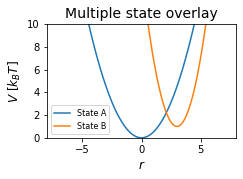

In [22]:
#Build System
#System Parameters:
yoff1 = 0
xoff1 = 0
force_constant = k1 = 1

entropic_difference = k2 = 3
potential_difference = yoff2 = 1
phase_space_distance = xoff2 = 3

#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
from ensembler.visualisation.plotPotentials import multiState_overlays

fig, _ = multiState_overlays([V_A,V_B])


## The Analyctical Solution: Nice if there is one
The Analytical solution for our problem can be calculated from the free energy of harmonic oscillators using

$F_i  = V_i - \frac{1}{2*\beta} log(\sqrt{\frac{2 \pi}{k_i \beta}})$.


As we know all parameters of the harmonic oscillators, we simply can calculate $F_i$ and $F_j$.
The difference of both quantities then results in the final free energy difference:

$ \Delta F_{ij} = F_j - F_i $


In [23]:
#Analytical Solution
beta = 1 # beta is in kT

F_A = yoff1 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k1*beta)))
F_B = yoff2 -(1/(2*beta)) * np.log(np.sqrt((2*np.pi)/(k2*beta)))
dF_AB_expected = F_B-F_A

print("expected dF: ", dF_expected)

expected dF:  1.2746530721670273


For this toy example it was easy to calculate the free energy difference.
But there is not always an analytical solution our problem.
As the functional of a problem gets more complex we can not rely on an analytical solution anymore.
In the following we are going to discuss some methods, that can be used in cases like this.

## Free Energy Pertubation - BAR/Zwanzig: a simplistic start
The journey through the free energy method landscape is started with a simple start; The Free Energy Pertubation method.
As we now assume to not know the analytical solution, we could for example use one state and simulate it, to explore its potential landscape.
If the phase space overlap of both states is high, we could sample all the important information for both states, from this one simulation.


### Sampling
Now we build first the two systems and run the simulations.

Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 5823.97it/s]


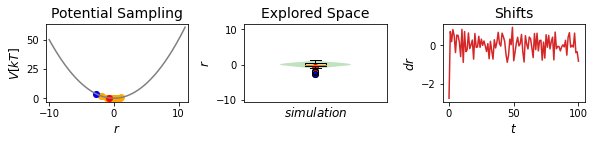

In [24]:
#Simulate the two states:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

##Build Systems

systemA = system(potential=V_A, sampler=sampler, temperature=temperature)
systemB = system(potential=V_B, sampler=sampler, temperature=temperature)

##Simulate:
systemA.simulate(steps)
stateA_traj = systemA.trajectory
_ = oneD_simulation_analysis_plot(systemA, limits_coordinate_space=np.linspace(-10,10) )

### Analysis
After simulating state A, the potential energies for state B can be calculated using our potential fuction.

#### Zwanzig Equation


$  dF_{ij_{Zwanzig}}(V_i, V_j) = - \beta \ln(\langle e^{-\beta(V_j-V_i)} \rangle_i ) $

In [27]:
VA_sampled_energies=stateA_traj.total_potential_energy[equilibration_steps:]
VB_sampled_energies=V_B.ene(stateA_traj.position[equilibration_steps:])

zwanz = zwanzigEquation(kT=True)
dF_AB_zwanzig = zwanz.calculate(Vi=VA_sampled_energies, Vj=VB_sampled_energies)

print("Expected Result: ", dF_AB_expected)
print("Zwanzig Result: ", dF_AB_zwanzig)
print()
print("Difference:", dF_AB_zwanzig - dF_AB_expected)


Expected Result:  1.2746530721670273
Zwanzig Result:  21.175624742442892

Difference: 19.900971670275865


#### Bennet Acceptance Ratio (BAR)

Equation:
$ dF_{ij_{BAR}}(V_i, V_j) = \ln(\frac{\langle f(V_i-Vj+C) \rangle_j}{\langle f(V_j-V_i-C) \rangle_i}) + C - ln(\frac{n_1}{n_0})$

with f as fermi function: 
- $ f(x) = \frac{1}{1+e^{-\beta x}}$

$dF_{ij_{BAR}}$ is calculated iterativley with $ddF_{ij_{BAR}}(V_i, V_j)$, till convergence

Simulation:  Simulation: 100%|██████████| 100/100 [00:00<00:00, 4249.20it/s]


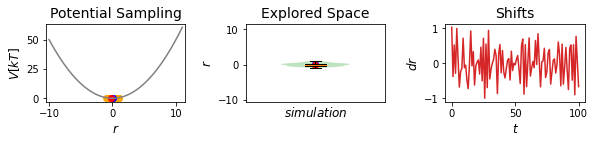

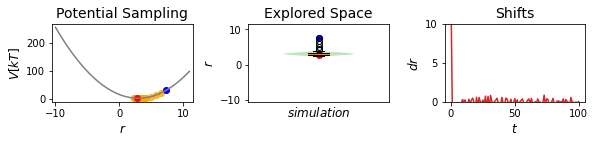

In [28]:
#Simulate the two states:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

##Build Systems

systemA = system(potential=V_A, sampler=sampler, temperature=temperature)
systemB = system(potential=V_B, sampler=sampler, temperature=temperature)

##Simulate:
systemA.simulate(steps, withdraw_traj=True, init_system=True)
stateA_traj = systemA.trajectory
_ = oneD_simulation_analysis_plot(systemA, limits_coordinate_space=np.linspace(-10,10))

systemB.simulate(steps, withdraw_traj=True, init_system=True)
stateB_traj = systemB.trajectory

#visualize
_ = oneD_simulation_analysis_plot(systemB, limits_coordinate_space=np.linspace(-10,10))
plt.ylim([0,10])
pass

NameError: name 'system1' is not defined

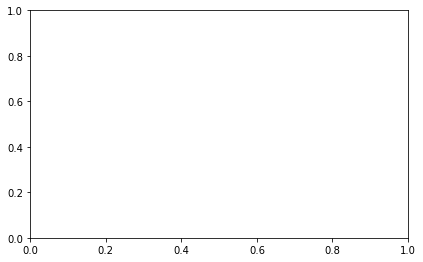

In [29]:
from ensembler import visualisation
    
positions = np.linspace(-10,10, 100)
fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
traj_pos = list(system1.trajectory.position)
ax[0].plot(positions, system1.potential.ene(positions), c="grey", label="state A", zorder=-10)
ene = systemA.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C0",alpha=0.8, label="simulation state A",s=8)
ax[0].set_ylim([0,8])

positions = np.linspace(-10,10, 100)
traj_pos = list(system2.trajectory.position)
ax[0].plot(positions, system2.potential.ene(positions), c="black", label="state B", zorder=-10)
ene = systemB.potential.ene(traj_pos)
ax[0].scatter(traj_pos, ene, c="C2",alpha=0.8, label="simulation state B",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
ax[0].legend()
ax[0].set_title("single state simulations")
fig.savefig("freeEnergyPertubation.pdf")

In [9]:
#Sampling l1
V11=V_A.ene(stateA_traj.position)
V21=V_B.ene(stateA_traj.position)

#Sampling l2
V12=V_A.ene(stateB_traj.position)
V22=V_B.ene(stateB_traj.position)

bar = bennetAcceptanceRatio(kT=True, convergence_radius=0.01, max_iterations=1000)
dF_bar = bar.calculate(Vj_i=V21, Vi_i=V11, Vi_j=V12, Vj_j=V22, verbose=False)

print()
print("Expected Result: ", dF_expected)
print("BAR Result: ", dF_bar)
print()
print("Difference:", dF_bar - dF_expected)



Final Iterations:  7  Result:  2.778772561864683

Expected Result:  1.2746530721670273
BAR Result:  2.778772561864683

Difference: 1.5041194896976555


## Coupling Methods
If the phase space overlap of the two state is low, the free energy estimate might deviate a lot from the real result.
This issue can be solved by coupling the phase space of the two states in a simulation.
Two ways of coupling will be discussed. 
The first one is $\lambda$-coupling which forms a linear combination of the two states, this is used for EXP and TI.
Second there is the exponential boltzmann coupling used in enveloping distribution sampling (EDS). 

### $\lambda$ - Coupling

This type of coupling is currently the most popular coupling method.

$H_{\lambda} = (1-\lambda) H_A + \lambda H_B $

### Build System

Text(0.5, 1.0, 'Sampled Potentials')

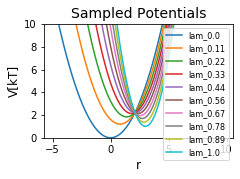

In [10]:
#Build Potential
V_perturbed = pot.linearCoupledPotentials(Va=V_A, Vb=V_B)

#Visualize
lambda_points = 10
positions = np.arange(-5,10, 0.2)
lambda_windows=np.linspace(0,1, lambda_points)

for lam in lambda_windows:
    V_perturbed.set_lambda(lam)
    ene =  V_perturbed.ene(positions)
    plt.plot(positions,ene, label="lam_"+str(round(lam, 2)))
    
plt.legend()

plt.ylim([0,10])
plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

### Sampling

In [ ]:
steps = int(simulation_steps_total_per_approach)#//(lambda_points)
equilibration_steps = 30
print(steps)
perturbed_system = perturbedSystem(potential=V_perturbed, sampler=sampler, temperature=temperature)

system_trajs = {}
for lam in lambda_windows:
    perturbed_system.set_lambda(lam)
    perturbed_system.simulate(steps, withdraw_traj=True, init_system=True)
    system_trajs.update({lam: perturbed_system.trajectory})


### Analysis

Sampling first we check the sampling

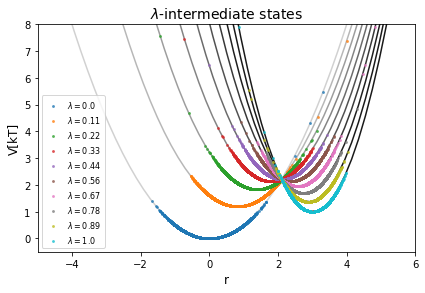

In [12]:
from ensembler import visualisation
from matplotlib import cm
#Visualize
positions = np.linspace(-10, 10, 100)
y_range = [-0.5, 8]


fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes = list([axes])
enes = []
all_lams = sorted(list(system_trajs.keys()))

for lamI in all_lams:
    trajI = system_trajs[lamI]
    V_perturbed.set_lambda(lamI)
    ene =  V_perturbed.ene(positions)
    enes.append(ene)
    if(lamI==1): 
        c="black"
    else:
        c = cm.get_cmap("binary")(lamI+0.2)
    
    axes[0].plot(positions,ene, c=c, zorder=-10,alpha=0.9)
    axes[0].scatter(trajI.position, V_perturbed.ene(trajI.position),s=8,alpha=0.8, linewidths=0, 
                    label="$\lambda=$"+str(round(lamI, 2)),)#c="orange")
    
logExp=list(map(lambda x: np.log(np.exp(x)), enes))

axes[0].legend()
axes[0].set_ylim(y_range)

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("$\lambda$-intermediate states")

axes[0].set_xlim([-5,6])


fig.savefig("linear_coupled.pdf")

### EXP with multiple lambda windows:
This method is calculating the energy difference between the different $\lambda$-points using the Zwanzig equation leading to a path from state A to state B.

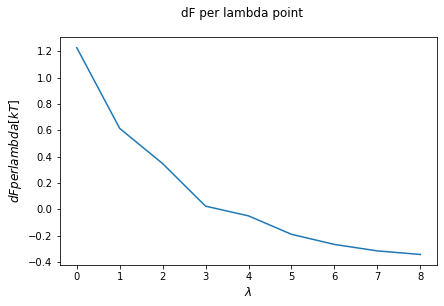


Expected Result:  1.2746530721670273
Sum of intermediates Result:  1.0565226506769683

Difference: -0.218130421490059


In [13]:
dA_i_fw = []
zwanz = zwanzigEquation()
all_lams = list(sorted(list(system_trajs.keys())))
for lamI, lamJ in zip(all_lams, all_lams[1:]):
    trajI = system_trajs[lamI]
    trajJ = system_trajs[lamJ]

    Vi_fw = trajI.total_potential_energy
    Vj_fw = trajJ.total_potential_energy

    
    dF_zwanzig_fw = zwanz.calculate(Vi=Vi_fw, Vj=Vj_fw)
    
    dA_i_fw.append(dF_zwanzig_fw)

fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
axes.plot(dA_i_fw)
axes.set_ylabel("$dFper lambda [kT]$")
axes.set_xlabel("$\lambda$")

fig.suptitle("dF per lambda point")

plt.show()

dF_FEP_10lambda = np.sum(dA_i_fw)

print()
print("Expected Result: ", dF_expected)
print("Sum of intermediates Result: ", dF_FEP_10lambda)
print()
print("Difference:", dF_FEP_10lambda - dF_expected)


#### Thermodynamic Integration (TI)
TI calculates the partial derivative $\langle \frac{\partial H}{\partial \lambda} \rangle_\lambda  $ for each $\lambda$-intermediate state and finally integrates over all intermediat states to retain the final free energy difference. 

$\int_0^1\langle \frac{\partial H}{\partial \lambda} \rangle_{\lambda} d\lambda $

Text(0.5, 0.98, '$dH/d\\lambda$ for each Lambda point')

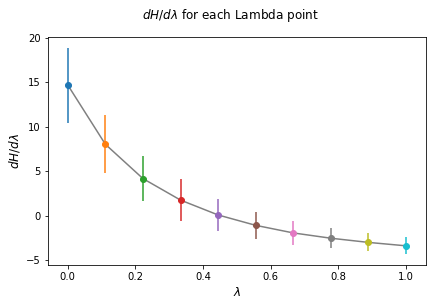

In [45]:
fig, axes = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)

lam_stats = {}
for lam in system_trajs:
    lam_mean, lam_std = np.mean(system_trajs[lam].dhdlam[equilibration_steps:]), np.std(system_trajs[lam].dhdlam[equilibration_steps:])
    lam_stats.update({lam:{"mean":lam_mean, "std": lam_std}})
    
    axes.scatter(lam, lam_mean)
    axes.errorbar(lam, lam_mean, lam_std)

axes.plot(sorted(lam_stats), [lam_stats[x]["mean"] for x in sorted(lam_stats)], color="grey", zorder=-1)
axes.set_ylabel("$dH/d\lambda$")
axes.set_xlabel("$\lambda$")

fig.suptitle("$dH/d\lambda$ for each Lambda point")


In [46]:
from scipy import integrate

lam = list(sorted(lam_stats.keys()))
means = [lam_stats[x]['mean'] for x in lam] 
stds = [lam_stats[x]['std'] for x in lam] 

dF_trapez = integrate.trapz(x=lam, y=means)
dF_err = integrate.trapz(x=lam, y=stds)

print()
print("Expected Result: ", dF_expected)
print("trapez Rule Result: ", dF_trapez, "+-", dF_err)
print()
print("Difference:", dF_trapez - dF_expected)



Expected Result:  1.2746530721670273
trapez Rule Result:  1.2294406039616153 +- 1.9408114041370321

Difference: -0.045212468205412026


## State Coupled - Enveloping Distribution Sampling (EDS)

### Build System

Text(0.5, 1.0, 'Sampled Potentials')

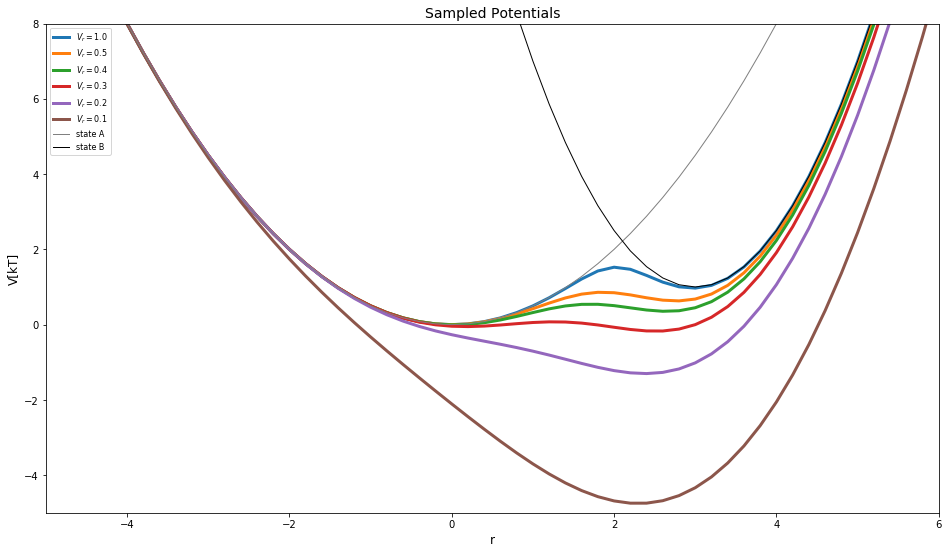

In [16]:
#Build Potential
s=1
Eoff = [0, 0]
V_eds = pot.envelopedPotential(V_is=[V_A,V_B] , s=s, eoff=Eoff)
s_values = np.array([ 1,0.5, 0.4, 0.3, 0.2, 0.1])

#Visualize
positions = np.arange(-10,15, 0.2)
fig = plt.figure(figsize=[16,9])

for s in s_values:
    V_eds.s=s
    plt.plot(positions,V_eds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,V_A.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,V_B.ene(positions), label="state B", lw=1, color="black")

V_eds.s=0.3
plt.legend()  
plt.ylim([-5,8])
plt.xlim([-5,6])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")

### Sampling

In [ ]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

good_s_value=0.3
eds_system = edsSystem(potential=V_eds, sampler=sampler, eds_s=good_s_value, eds_Eoff=Eoff, temperature=temperature)

eds_system.simulate(steps, withdraw_traj=True, init_system=True)
eds_traj = eds_system.trajectory

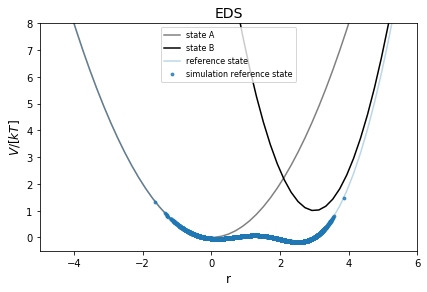

In [18]:
from ensembler import visualisation
    
traj = eds_traj.iloc[equilibration_steps:]
positions = np.linspace(-10,10, 100)
V_A_ene = V_A.ene(positions)
V_B_ene = V_B.ene(positions)
V_eds.s = traj.s[equilibration_steps]
eds_ene = V_eds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.total_potential_energy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, V_A_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, V_B_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C0", label="reference state", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C0",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")

ax[0].legend()
ax[0].set_title("EDS")

fig.savefig("EDS_sampling.pdf")

### Analysis
#### Zwanzig-EDS_Evaluation

In [19]:
rew_zwanz = threeStateZwanzig(kT=True)

traj_positions = eds_traj.position[equilibration_steps:]
Vrr = eds_traj.total_potential_energy[equilibration_steps:]
VAr = V_A.ene(traj_positions)
VBr = V_B.ene(traj_positions)

dF_EDS = rew_zwanz.calculate(Vi=VAr, Vj=VBr, Vr=Vrr)

print("dF ", dF_EDS)
print("deviation: ", dF_EDS-dF_expected)


dF  1.5542239662332862
deviation:  0.2795708940662589


#### BAR-EDS_Evaluation

In [20]:

traj_positions = eds_traj.position[equilibration_steps:]

#Sampling l1
V11=V_A.ene(stateA_traj.position)
V21=V_B.ene(stateA_traj.position)
Vr1 = V_eds.ene(list(stateA_traj.position))

#Sampling l2
V12=V_A.ene(stateB_traj.position)
V22=V_B.ene(stateB_traj.position)
Vr2 = V_eds.ene(list(stateB_traj.position))

Vrr = eds_traj.total_potential_energy[equilibration_steps:]
V1r = V_A.ene(traj_positions)
V2r = V_B.ene(traj_positions)

bar = bennetAcceptanceRatio(kT=True)
setattr(bar, "verbose", False)
df_BAR_1R = bar.calculate(Vj_i=V1r, Vi_i=Vrr, Vi_j=Vr1, Vj_j=V11,)
dF_EDS = rew_zwanz.calculate(Vi=V1r, Vj=V2r, Vr=Vrr)
df_BAR_2R = bar.calculate(Vj_i=V2r, Vi_i=Vrr, Vi_j=Vr2, Vj_j=V22)

dF_EDS_bar = df_BAR_1R-dF_EDS+df_BAR_2R

print("2R", df_BAR_2R, "rr", dF_EDS, "1R", df_BAR_1R)
print("dF_BAR:  ", dF_EDS_bar)
print("deviation: ", dF_EDS_bar-dF_expected)






Final Iterations:  5  Result:  0.6618080755378104

Final Iterations:  7  Result:  2.060036452897056
2R 2.060036452897056 rr 1.5542239662332862 1R 0.6618080755378104
dF_BAR:   1.1676205622015803
deviation:  -0.107032509965447


## Hybrid Methods - $\lambda$-EDS

### Build System

0 	 100.0
1 	 1.0
2 	 0.5
3 	 0.3
4 	 0.2
5 	 0.1


Text(0.5, 1.0, 'Sampled Potentials')

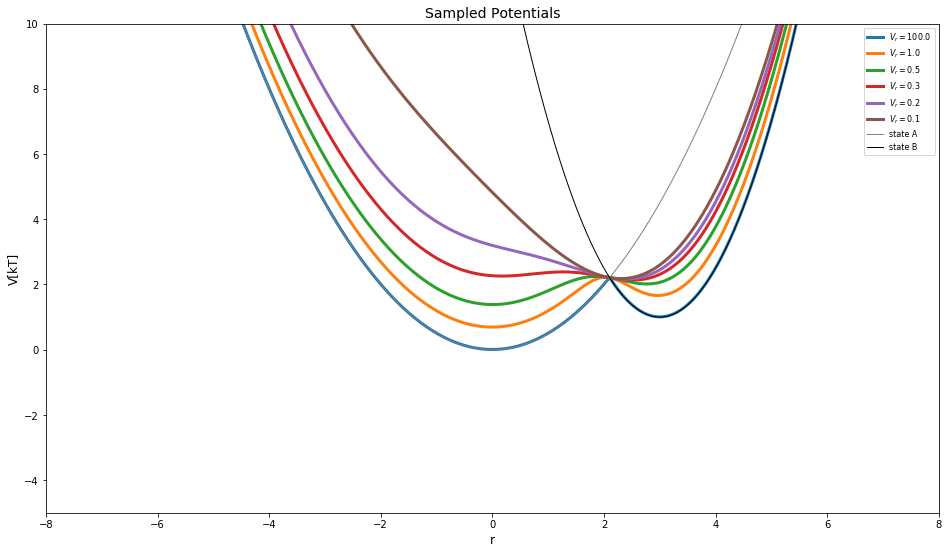

In [21]:
#Build Potential
s=1
Eoff = [0,0]
V_hleds = pot.lambdaEDSPotential(V_is=[V_A,V_B] , s=s, lam=0.5)
s_values = np.array([100, 1, 0.5, 0.3, 0.2, 0.1])

#Visualize
positions = np.linspace(-10,10, 1000)
fig = plt.figure(figsize=[16,9])

for ind,s in enumerate(s_values):
    print(ind, "\t", s)
    V_hleds.s=s
    plt.plot(positions,V_hleds.ene(positions), lw=3, label="$V_r="+str(round(s,3))+"$")

plt.plot(positions,V_A.ene(positions), label="state A", lw=1, color="grey")
plt.plot(positions,V_B.ene(positions), label="state B", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


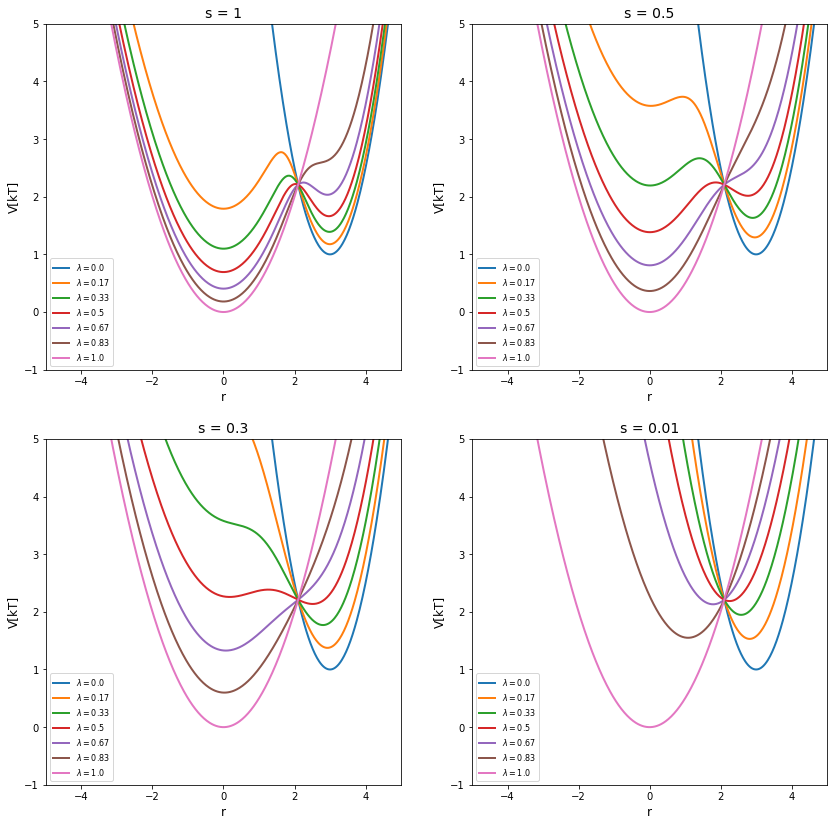

In [22]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[14,14])
axes = np.concatenate(axes)
s_values = [1, 0.5,  0.3, 0.01]
lams=list(sorted(list(np.linspace(start=0, stop=1, num=7))))


for ax, s in zip(axes, s_values):
    V_hleds.s= s
    for ind,lam in enumerate(lams):
        V_hleds.lam=lam
        ax.plot(positions,V_hleds.ene(positions), lw=2, label="$\lambda="+str(round(lam,2))+"$")

    #ax.plot(positions,V_A.ene(positions), label="state A", lw=1, color="grey", zorder=10)
    #ax.plot(positions,V_B.ene(positions), label="state B", lw=1, color="black", zorder=10)

    ax.legend()  
    ax.set_ylim([-1,5])
    ax.set_xlim([-5,5])

    ax.set_ylabel("V[kT]")
    ax.set_xlabel("r")
    ax.set_title("s = "+str(s))

### Simulate

In [ ]:
steps = simulation_steps_total_per_approach
equilibration_steps = 100

hleds_system = edsSystem(potential=V_hleds, sampler=sampler, eds_Eoff=Eoff, temperature=temperature)

hleds_simulation_trajs = []
good_s_value = 0.3
hleds_system.set_s(good_s_value)
hleds_system.potential.lam = 0.5
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj = hleds_system.trajectory


In [24]:
#Simulation at other lambdas

hleds_system.potential.lam = 0.25
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj2 = hleds_system.trajectory


hleds_system.potential.lam = 0.75
hleds_system.simulate(steps, withdraw_traj=True, init_system=True)
hleds_simulation_traj3 = hleds_system.trajectory

Simulation:  Simulation: 100%|██████████| 10000/10000 [00:05<00:00, 1731.58it/s]


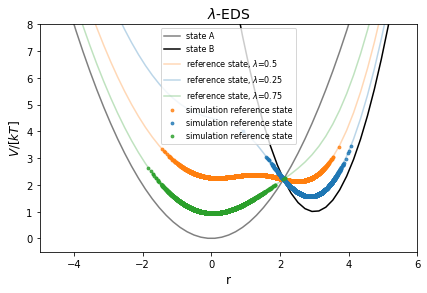

In [25]:
from ensembler import visualisation
    
traj = hleds_simulation_traj.iloc[equilibration_steps:]
traj2 = hleds_simulation_traj2.iloc[equilibration_steps:]
traj3 = hleds_simulation_traj3.iloc[equilibration_steps:]

positions = np.linspace(-10,10, 100)
V_A_ene = V_A.ene(positions)
V_B_ene = V_B.ene(positions)
V_hleds.s = traj.s[equilibration_steps]

V_hleds.lam = 0.5
eds_ene = V_hleds.ene(positions)
V_hleds.lam = 0.25
eds_ene1 = V_hleds.ene(positions)
V_hleds.lam = 0.75
eds_ene2 = V_hleds.ene(positions)

traj_pos = list(traj.position)
traj_ene = list(traj.total_potential_energy)
traj_pos2 = list(traj2.position)
traj_ene2 = list(traj2.total_potential_energy)
traj_pos3 = list(traj3.position)
traj_ene3 = list(traj3.total_potential_energy)

fig, ax = plt.subplots(ncols=1, figsize=visualisation.figsize_doubleColumn)
ax = list([ax])
ax[0].plot(positions, V_A_ene, c="grey", label="state A", zorder=-10,)
ax[0].plot(positions, V_B_ene, c="black", label="state B", zorder=-10)
ax[0].plot(positions, eds_ene, c="C1", label="reference state, $\lambda$=0.5", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene1, c="C0", label="reference state, $\lambda$=0.25", zorder=-10,alpha=0.3)
ax[0].plot(positions, eds_ene2, c="C2", label="reference state, $\lambda$=0.75", zorder=-10,alpha=0.3)

ax[0].scatter(traj_pos, traj_ene, c="C1",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos2, traj_ene2, c="C0",alpha=0.8, label="simulation reference state",s=8)
ax[0].scatter(traj_pos3, traj_ene3, c="C2",alpha=0.8, label="simulation reference state",s=8)

ax[0].set_ylim([-0.5,8])
ax[0].set_xlim([-5,6])
ax[0].set_xlabel("r")
ax[0].set_ylabel("$V/[kT]$")
    
ax[0].legend()
ax[0].set_title("$\lambda$-EDS")

fig.savefig("hlEDS_sampling.pdf")

### Analysis

In [ ]:
rew_zwanz = threeStateZwanzig(kT=True)
zwanz = zwanzigEquation(kT=True)

traj_positions = hleds_simulation_traj.position[equilibration_steps:]
Vr = hleds_simulation_traj.total_potential_energy[equilibration_steps:]
V1 = V_A.ene(traj_positions)
V2 = V_B.ene(traj_positions)

dF_leds = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)

print("dF ", dF_leds)
print("deviation: ", dF_leds-dF_expected)
    


## Enhanced Sampling with system Coupling

### Conveyor Belt TI

#### Build System

In [5]:
import ensembler.ensemble.replicas_dynamic_parameters as cvb
from ensembler.system import perturbed_system

#CHEKC HERE V_A and V_B die
equilibration_steps = 100
numsys = 4
V_perturbed = pot.linearCoupledPotentials(Va=V_A, Vb=V_B)

lam_system = perturbed_system.perturbedSystem(potential=V_perturbed , sampler=sampler, temperature=temperature)
conveyorBelt=cvb.conveyorBelt(0.0, numsys, system=lam_system, build=False)


In [13]:
conveyorBelt.get_conveyorbelt_trajectory()

,Step,capital_lambda,TotE,biasE,doAccept
0,877,2.191132,10.783418,10.783418,True
1,878,2.437016,8.061567,8.061567,True
2,879,2.236692,8.104444,8.104444,True
3,880,2.056680,8.637634,8.637634,True
4,881,2.554761,8.055420,8.055420,True
5,882,2.554761,7.404010,0.000000,False
6,883,2.554761,7.586980,0.000000,False
7,884,2.464641,7.708552,7.708552,True
8,885,2.075930,7.426145,7.426145,True
9,886,1.965528,7.175112,7.175112,True


#### Simulate

In [14]:
conveyorBelt.simulate(10) #simulation_steps_total_per_approach
cvb_trajs = conveyorBelt.get_trajectories()



		 2.5007664452538556
		 3.915700891218128
		 6.390351214599206
		 7.819742415649875
7.819742415649875
		 2.446852308809916
		 3.72541156173161
		 6.123674582910531
		 7.099530472002049
7.099530472002049
		 2.11706181861073
		 3.9570581574652044
		 6.268485025969617
		 7.257604334870796
7.257604334870796
		 2.4758313825029763
		 4.33175803530988
		 6.407726898062004
		 7.606184341621917
7.606184341621917
		 2.192735078859106
		 3.487548593133556
		 6.06682374889868
		 7.31317446973069
7.31317446973069
		 2.627056123870341
		 3.934273270559256
		 6.097893897024809
		 7.362567317487656
7.362567317487656
		 2.1849059775788806
		 3.50341870922289
		 5.764013173119569
		 7.0143310106988395
7.0143310106988395
		 2.735026510709843
		 4.195453666517744
		 6.785761430443933
		 8.260380656492632
8.260380656492632
		 2.272731984672065
		 3.7552450280180363
		 6.082550683501648
		 7.527461305292949
7.527461305292949
		 2.281298438178087
		 3.8123663223271738
		 6.089974400076093
		 7.5982775119221

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=style.figsize_doubleColumn, sharex=True)
keys=list(sorted(list(cvb_trajs.keys())))
for key in keys:
    axes[key].plot(cvb_trajs[key].lam)
    axes[key].set_ylabel("$\lambda_"+str(key+1)+"$")
    if(key == keys[-1]):    axes[key].set_xlabel("$time [steps]$")
    axes[key].set_ylim([0,1])
fig.suptitle("Conveyor belt replica sampling", y=1.05)
fig.tight_layout()

#### Analysis

<BarContainer object of 50 artists>

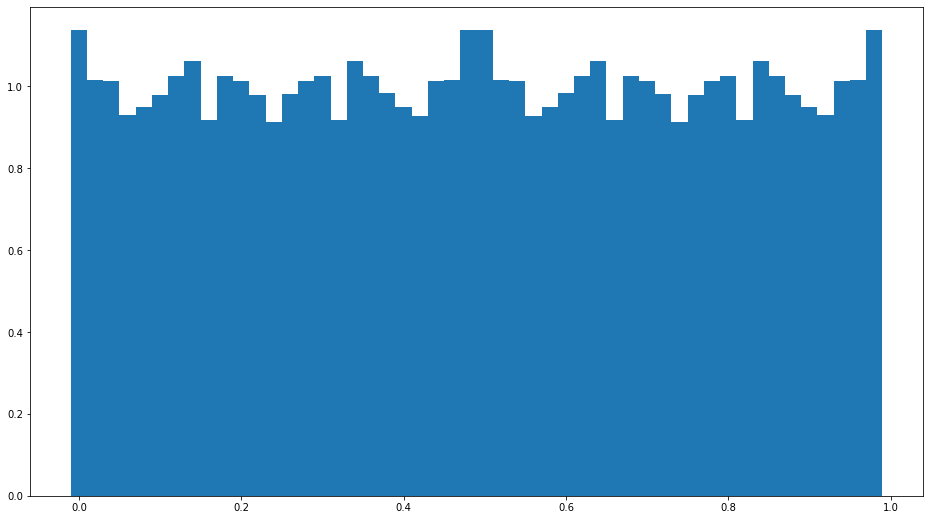

In [31]:
import pandas as pd
nbins=50
mega_traj = pd.concat(list(map(lambda x: x[equilibration_steps:], cvb_trajs.values())), ignore_index=True)

frequencies, lam_bins = np.histogram(list(sorted(np.unique(mega_traj.lam))), bins=nbins, density=True)
plt.figure(figsize=[16,9])
plt.bar(x=lam_bins[:-1], height=frequencies, width=1/nbins)

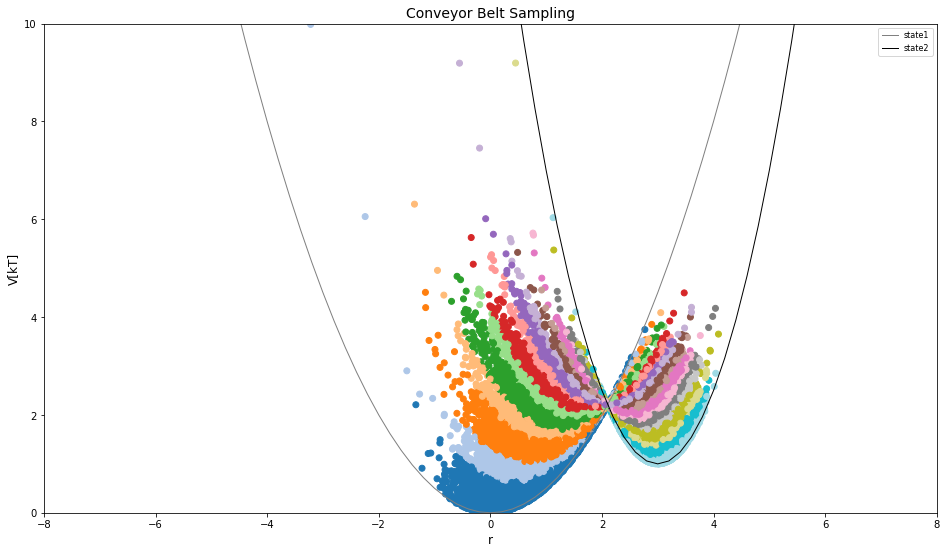

In [32]:
import pandas as pd
mega_traj = pd.concat(list(cvb_trajs.values()), ignore_index=True)

def find_nearest_bin(array,value):
    cbins =[]
    for val in value:
        idx = np.argmin(np.abs(array-val))
        cbins.append(idx)
    return cbins

discrete_traj = np.array(find_nearest_bin(value=mega_traj.lam[equilibration_steps:], array=lam_bins))

fig, axes = plt.subplots(ncols=1, figsize=[16,9])
axes = [axes]
axes[0].scatter(list(mega_traj.position[equilibration_steps:]), mega_traj.total_potential_energy[equilibration_steps:], c=discrete_traj, cmap="tab20")

#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)
positions = np.arange(-10,10, 0.2)
axes[0].plot(positions, V_A.ene(positions), label="state1", lw=1, color="grey")
axes[0].plot(positions, V_B.ene(positions), label="state2", lw=1, color="black")

axes[0].legend()  
axes[0].set_ylim([0,10])
axes[0].set_xlim([-8,8])

axes[0].set_ylabel("V[kT]")
axes[0].set_xlabel("r")
axes[0].set_title("Conveyor Belt Sampling")
fig.savefig("CVB_sampling.pdf")


Expected Result:  1.2746530721670273
trapez Rule Result:  1.113409988745998 +- -3.087456810148474

Difference: -0.16124308342102922


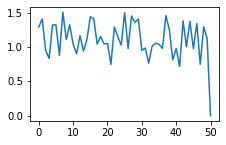

In [33]:
from scipy import integrate

lambda_stat = mega_traj[["lam","dhdlam"]]

means_cvb = np.nan_to_num([np.mean(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)])
std_cvb = np.nan_to_num([np.std(lambda_stat.loc[np.where(discrete_traj==x+1)].dhdlam) for x in range(nbins+1)] )

plt.plot(means_cvb)

dF_cvb_trapez = integrate.trapz(x=lam_bins, y=means_cvb)
dF_err = integrate.trapz(x=means_cvb, y=std_cvb)

print()
print("Expected Result: ", dF_expected)
print("trapez Rule Result: ", dF_cvb_trapez, "+-", dF_err)
print()
print("Difference:", dF_cvb_trapez - dF_expected)


### RE-EDS

#### Build System

[0, 0]
DO trials:  100 steps:  100
[1.0, 0.7742636826811271, 0.599484250318941, 0.4641588833612779, 0.35938136638046275, 0.2782559402207124, 0.2154434690031884, 0.1668100537200059, 0.1291549665014884, 0.1]


Text(0.5, 1.0, 'Sampled Potentials')

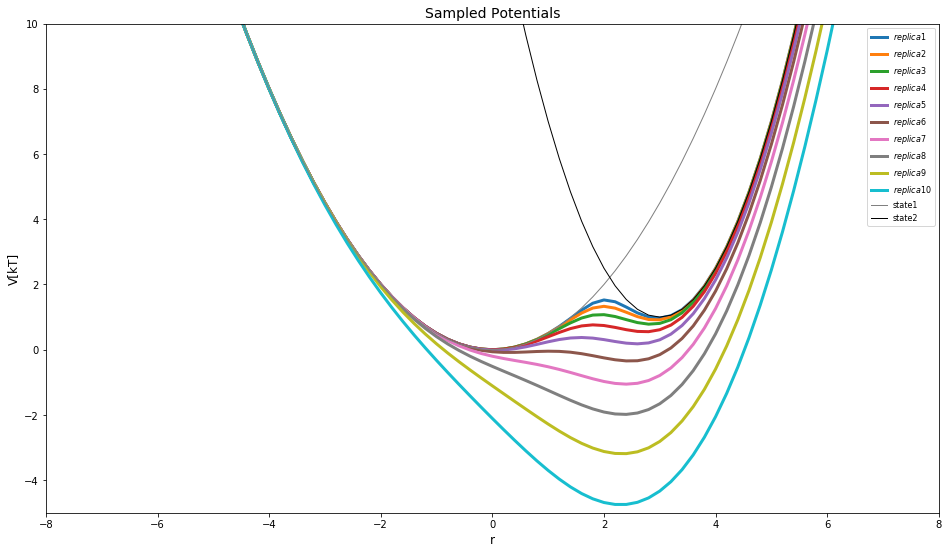

In [34]:
#potential
Eoff = [0,1]
V_eds = pot.envelopedPotential(V_is=[V_A,V_B])


##System
eds_system = edsSystem(sampler=sampler, potential=V_eds, start_position=4, temperature=temperature)
eds_system.Eoff = Eoff
print(eds_system.potential.Eoff)

##Ensemble
from ensembler.ensemble import replica_exchange
##Ensemble Settings:
s_values = np.logspace(start=0, stop=-1, num=10)
trials=simulation_steps_total_per_approach//100
steps_between_trials=simulation_steps_total_per_approach//trials

print("DO trials: ", trials, "steps: ", steps_between_trials)
ensemble = replica_exchange.replicaExchangeEnvelopingDistributionSampling(system=eds_system, exchange_criterium=None,
                                                                          s_range=s_values, steps_between_trials=steps_between_trials)
print([replica.s for repID, replica in ensemble.replicas.items()])

#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

#Visualize
positions = np.arange(-10,10, 0.2)
fig = plt.figure(figsize=[16,9])

for ind,replica in ensemble.replicas.items():
    plt.plot(positions,replica.potential.ene(positions), lw=3, label="$replica "+str(ind+1)+"$")

plt.plot(positions,V_A.ene(positions), label="state1", lw=1, color="grey")
plt.plot(positions,V_B.ene(positions), label="state2", lw=1, color="black")


plt.legend()  
plt.ylim([-5,10])
plt.xlim([-8,8])

plt.ylabel("V[kT]")
plt.xlabel("r")
plt.title("Sampled Potentials")


#### Simulate

In [ ]:
ensemble.simulate(trials, reset_ensemble=True)
reeds_trajs = ensemble.replica_trajectories


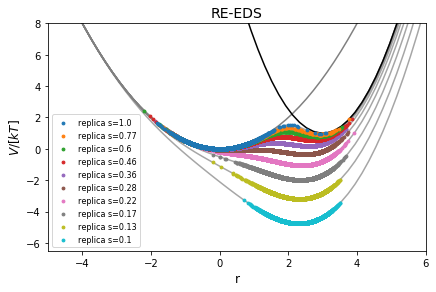

In [36]:

positions = np.linspace(-10,10)
fig, ax = plt.subplots(ncols=1, figsize=style.figsize_doubleColumn)
eqil=100
keys = sorted(list(reeds_trajs.keys()), reverse=False)
              
positions = np.linspace(-10,10, 100)
V_A_ene = V_A.ene(positions)
V_B_ene = V_B.ene(positions)

ax.plot(positions, V_A_ene, c="grey", zorder=-10,)
ax.plot(positions, V_B_ene, c="black", zorder=-10)

for traj in keys:
    s =  round(ensemble.replicas[traj].s,2)
    ax.plot(positions, ensemble.replicas[traj].potential.ene(positions), c="grey", alpha=0.7, zorder=-60)
    min_e = np.min(reeds_trajs[traj].total_potential_energy[eqil:])
    ax.scatter(reeds_trajs[traj].position[eqil:], reeds_trajs[traj].total_potential_energy[eqil:], zorder=-traj, c="C"+str(traj),s=8, label="replica s="+str(s))

ax.set_ylim([-6.5,8])
ax.set_xlim([-5,6])
ax.set_xlabel("r")
ax.set_ylabel("$V/[kT]$")
ax.legend()
ax.set_title("RE-EDS")
fig.savefig("REEDS.pdf")

#### Analysis

In [ ]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.hist(reeds_trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


In [ ]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [reeds_trajs[x].total_potential_energy[100:] for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
    
#ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

In [ ]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [ ]:
rew_zwanz = threeStateZwanzig(kT=True)
zwanz = zwanzigEquation(kT=True)
equilibration_steps=10
#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].total_potential_energy[equilibration_steps:]
    V1 = V_A.ene(traj_positions)
    V2 = V_B.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    dFresults.append(dFRew_zwanz)

print()
print("\tExpected Result: ", dF_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dF_expected)])))
print("\n\n\n")

## Final Results

In [ ]:
md_str = "| method | dF  | deviation |\n"
md_str += "|---|---|---|\n"
md_str += "| analytical   | "+str(np.round(dF_expected,2))+"  |   | \n"
md_str += "| Zwanzig   | "+str(np.round(dF_zwanzig,2))+"  | "+str(np.round(dF_zwanzig-dF_expected,2))+" | \n"
md_str += "| BAR   | "+str(np.round(dF_bar,2))+"  | "+str(np.round(dF_bar-dF_expected,2))+" | \n"

md_str += "| FEP 10-$\lambda$ Points   | "+str(np.round(dF_FEP_10lambda,2))+"  | "+str(np.round(dF_FEP_10lambda-dF_expected,2))+" | \n"
md_str += "| TI 10-$\lambda$ Points  | "+str(np.round(dF_trapez,2))+"  | "+str(np.round(dF_trapez-dF_expected,2))+" | \n"

md_str += "| EDS   | "+str(np.round(dF_EDS,2))+"  | "+str(np.round(dF_EDS-dF_expected,2))+" | \n"
md_str += "| EDS-BAR   | "+str(np.round(dF_EDS_bar,2))+"  | "+str(np.round(dF_EDS_bar-dF_expected,2))+" | \n"
md_str += "| $\lambda$ EDS   | "+str(np.round(dF_leds,2))+"  | "+str(np.round(dF_leds-dF_expected,2))+" | \n"

md_str += "| conveyor belt TI   | "+str(np.round(dF_cvb_trapez,2))+"  | "+str(np.round(dF_cvb_trapez-dF_expected,2))+" | \n"
#md_str += "| RE-DS   | "+str(np.round(dFresults[0],2))+"  | "+str(np.round(dFresults[0]-dF_expected,2))+" | \n"


from IPython.display import display, Markdown, Latex
display(Markdown(md_str))


In [ ]:
trajs = ensemble.get_trajectories()

positions = np.linspace(-10,10)
fig, axes = plt.subplots(ncols=len(trajs), figsize=[16,9])
eqil=100
for traj, ax in zip(reeds_trajs, axes):
    ax.hist(reeds_trajs[traj].position[eqil:])
    ax.set_xlim([-4,8])
    ax.set_title("replica"+str(traj))


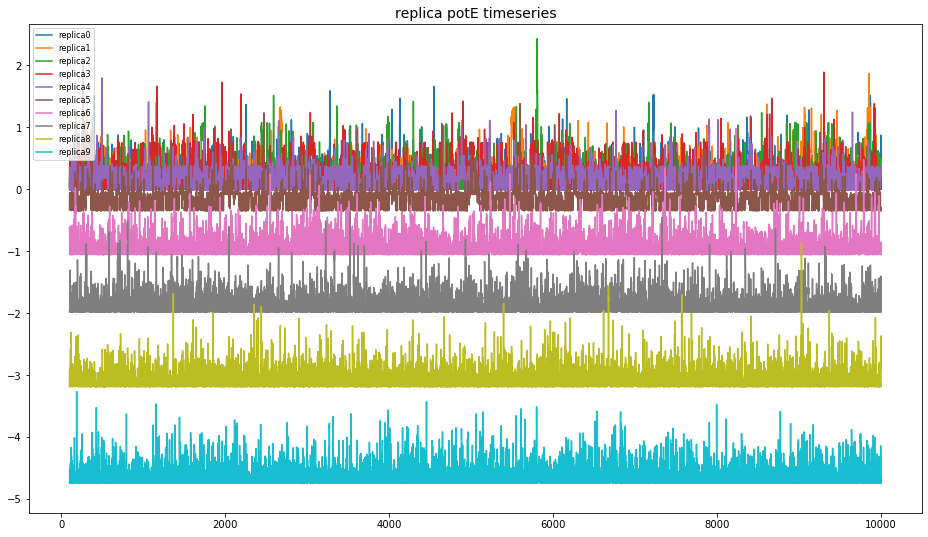

In [38]:

fig, ax = plt.subplots(ncols=1, figsize=[16,9])
enes = [reeds_trajs[x].total_potential_energy[100:] for x in sorted(trajs)] 
min_e = np.min(enes)
max_e = np.max(enes)

for ind, ene in enumerate(enes):
    ax.plot(ene, label="replica"+str(ind))
    
#ax.vlines([steps_between_trials*x for x in range(trials)], ymin=min_e, ymax=max_e, label="exchange", lw=0.1)
ax.set_title("replica potE timeseries")
ax.set_ylim(1.1*min_e, 1.1*max_e)
ax.legend()

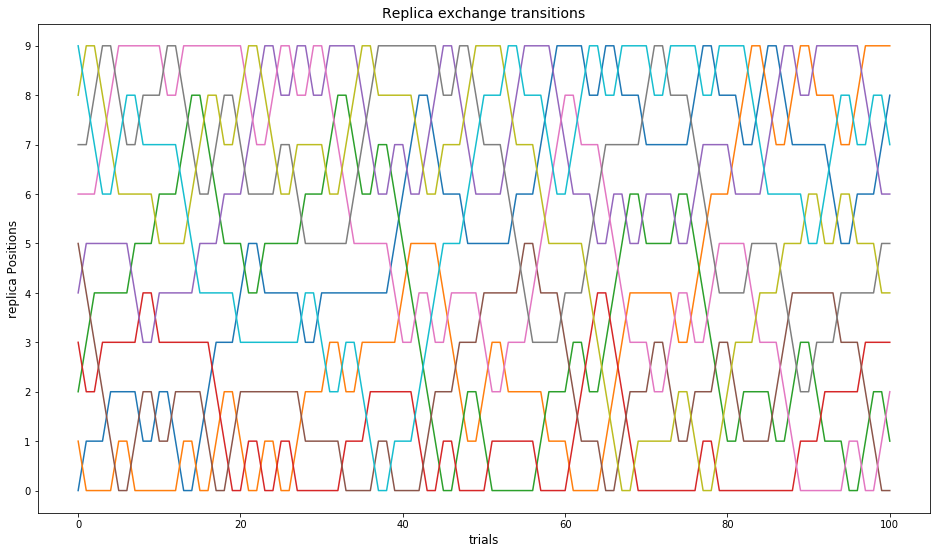

In [39]:
stats= ensemble.exchange_information
replicas = np.unique(ensemble.exchange_information.replicaID)
trials = np.unique(ensemble.exchange_information.nExchange)

import itertools as it

fig, ax = plt.subplots(ncols=1, figsize=[16,9])

replica_positions = {}
for replica in replicas:
    replica_positions.update({replica: stats.loc[stats.replicaID==replica].replicaPositionI})

    x = trials
    y = replica_positions[replica]

    ax.plot(x,y , label="replica_"+str(replica))

#plt.yticks(replicas+1, reversed(replicas+1))
ax.set_yticks(ticks=replicas)
ax.set_yticklabels(labels=replicas)

ax.set_ylabel("replica Positions")
ax.set_xlabel("trials")
ax.set_title("Replica exchange transitions")
if(len(replicas)<10): plt.legend()

In [40]:
rew_zwanz = threeStateZwanzig(kT=True)
zwanz = zwanzigEquation(kT=True)
equilibration_steps=10
#State Potentials
V_A = pot.harmonicOscillatorPotential(k=k1, x_shift=xoff1, y_shift=yoff1) 
V_B = pot.harmonicOscillatorPotential(k=k2, x_shift=xoff2, y_shift=yoff2)

dFresults = []
s_vals = []
for ind,key in enumerate(reeds_trajs):
    s_vals.append(reeds_trajs[key].s[1])
    traj_positions = reeds_trajs[key].position[equilibration_steps:]
    Vr = reeds_trajs[key].total_potential_energy[equilibration_steps:]
    V1 = V_A.ene(traj_positions)
    V2 = V_B.ene(traj_positions)

    dFRew_zwanz = rew_zwanz.calculate(Vi=V1, Vj=V2, Vr=Vr)
    dFresults.append(dFRew_zwanz)

print()
print("\tExpected Result: ", dF_expected)
print("s\t\tdF\t\tdiff")
print("\n".join(map(str, ["\t\t".join(map(str, np.round(x,5))) for x in  zip(s_vals, dFresults, dFresults - dF_expected)])))
print("\n\n\n")


	Expected Result:  1.2746530721670273
s		dF		diff
1.0		6.79899		5.52434
0.77426		4.77604		3.50138
0.59948		3.97879		2.70414
0.46416		3.30804		2.03338
0.35938		2.4357		1.16105
0.27826		1.19616		-0.07849
0.21544		0.08029		-1.19436
0.16681		-0.29597		-1.57062
0.12915		-0.32992		-1.60458
0.1		-0.46653		-1.74118






## Final Results

In [41]:
md_str = "| method | dF  | deviation |\n"
md_str += "|---|---|---|\n"
md_str += "| analytical   | "+str(np.round(dF_expected,2))+"  |   | \n"
md_str += "| Zwanzig   | "+str(np.round(dF_zwanzig,2))+"  | "+str(np.round(dF_zwanzig-dF_expected,2))+" | \n"
md_str += "| BAR   | "+str(np.round(dF_bar,2))+"  | "+str(np.round(dF_bar-dF_expected,2))+" | \n"

md_str += "| FEP 10-$\lambda$ Points   | "+str(np.round(dF_FEP_10lambda,2))+"  | "+str(np.round(dF_FEP_10lambda-dF_expected,2))+" | \n"
md_str += "| TI 10-$\lambda$ Points  | "+str(np.round(dF_trapez,2))+"  | "+str(np.round(dF_trapez-dF_expected,2))+" | \n"

md_str += "| EDS   | "+str(np.round(dF_EDS,2))+"  | "+str(np.round(dF_EDS-dF_expected,2))+" | \n"
md_str += "| EDS-BAR   | "+str(np.round(dF_EDS_bar,2))+"  | "+str(np.round(dF_EDS_bar-dF_expected,2))+" | \n"
md_str += "| $\lambda$ EDS   | "+str(np.round(dF_leds,2))+"  | "+str(np.round(dF_leds-dF_expected,2))+" | \n"

md_str += "| conveyor belt TI   | "+str(np.round(dF_cvb_trapez,2))+"  | "+str(np.round(dF_cvb_trapez-dF_expected,2))+" | \n"
#md_str += "| RE-DS   | "+str(np.round(dFresults[0],2))+"  | "+str(np.round(dFresults[0]-dF_expected,2))+" | \n"


from IPython.display import display, Markdown, Latex
display(Markdown(md_str))


| method | dF  | deviation |
|---|---|---|
| analytical   | 1.27  |   | 
| Zwanzig   | 8.57  | 7.29 | 
| BAR   | 2.78  | 1.5 | 
| FEP 10-$\lambda$ Points   | 1.06  | -0.22 | 
| TI 10-$\lambda$ Points  | 1.23  | -0.05 | 
| EDS   | 1.55  | 0.28 | 
| EDS-BAR   | 1.17  | -0.11 | 
| $\lambda$ EDS   | 1.71  | 0.44 | 
| conveyor belt TI   | 1.11  | -0.16 | 
